# Train

In [2]:
import numpy as np
import pandas as pd 
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import csv
import tensorflow as tf
from PIL import Image
import os
import keras
import sys

from keras.preprocessing import image
from tensorflow.keras.preprocessing import image as im
import time
import datetime

from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback
from keras import regularizers
from keras import backend as K
from sklearn.preprocessing import OneHotEncoder

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Input, AveragePooling2D
from keras.layers import Activation, Flatten, Dense, Dropout

import shutil

In [3]:
# Train phase

tf.keras.backend.set_learning_phase(1)

In [4]:
# Choose GPU

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
# 1) Path to train and test datasets
train_dir = "/home/linnik/Datasets/Signs/38_Classes/train/"   
test_dir = "/home/linnik/Datasets/Signs/38_Classes/test/"


# 2) Target width and height of input images, number of classes, number of train and test images, batch size, epochs
img_height, img_width = 72, 72
n_classes = len(os.listdir(train_dir))
nb_train_samples = sum([len(os.listdir(train_dir + folder)) for folder in os.listdir(train_dir)])
nb_test_samples = sum([len(os.listdir(test_dir + folder)) for folder in os.listdir(test_dir)])
batch_size = 128
epochs = 100


# 3) Name of file where will be saved trained model
model_name = "/home/linnik/Nets/Sign_ResNetM_72X72x3_38.hdf5"


# 4) Compile parametrs
loss_ = 'categorical_crossentropy'
optimizer_ = 'adam'
metrics_ = ['acc']

In [6]:
train_datagen = ImageDataGenerator(
    rescale = 1.0 / 255,
    zoom_range = 0.2,
    rotation_range = 5,
    width_shift_range = img_width // 3,
    height_shift_range = img_height // 3,
    horizontal_flip = False,
    vertical_flip = False)

test_datagen = ImageDataGenerator(rescale = 1.0 / 255)

In [7]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = 'categorical')

Found 122294 images belonging to 38 classes.
Found 16984 images belonging to 38 classes.


In [8]:
train_generator.class_indices

{'00': 0,
 '01': 1,
 '02': 2,
 '03': 3,
 '04': 4,
 '05': 5,
 '06': 6,
 '07': 7,
 '08': 8,
 '09': 9,
 '10': 10,
 '11': 11,
 '12': 12,
 '13': 13,
 '14': 14,
 '15': 15,
 '16': 16,
 '17': 17,
 '18': 18,
 '19': 19,
 '20': 20,
 '21': 21,
 '22': 22,
 '23': 23,
 '24': 24,
 '25': 25,
 '26': 26,
 '27': 27,
 '28': 28,
 '29': 29,
 '30': 30,
 '31': 31,
 '32': 32,
 '33': 33,
 '34': 34,
 '35': 35,
 '36': 36,
 '37': 37}

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(72, 72, 3)


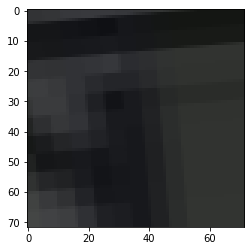

In [9]:
# Check size

for x, y in train_generator:
    plt.imshow(x[0])
    print(y[0])
    print(x[0].shape)
    break

In [10]:
def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """A block that has a conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: default 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filters of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x

def resNetM(input_shape, classes):
    img_input = Input(shape=input_shape)

    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', name='conv1')(img_input)
    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')

    x = AveragePooling2D((3, 3), name='avg_pool')(x)

    x = Flatten()(x)
    #x = Dense(512, activation='relu', name='fc01')(x)
    #x = Dense(200, activation='relu', name='fc02')(x)
    #x = Dropout(0.3, name='dr01')(x)
    x = Dense(classes, activation='softmax', name='fc5')(x)

    inputs = img_input

    model = Model(inputs, x, name='resnetM')

    return model

In [11]:
# Create and compile your own model

model = resNetM((img_height, img_width, 3), n_classes)
model.compile(loss = loss_, optimizer = optimizer_, metrics = metrics_)

In [12]:
# Callbacks

early_stop = EarlyStopping(monitor = 'val_loss', patience = 8, verbose = 1, min_delta = 1e-4)
reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.1, patience = 4, verbose = 1, min_delta = 1e-4)
check = ModelCheckpoint(filepath = model_name, monitor = "val_acc", save_best_only = True)

callbacks_list = [early_stop, reduce_lr, check]

In [13]:
%%time

# Train model

model_history = model.fit_generator(
    train_generator,
    epochs = epochs,
    validation_data = test_generator,
    validation_steps = nb_test_samples // batch_size,
    callbacks = callbacks_list,
    steps_per_epoch = nb_train_samples // batch_size)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/100
155/955 [===>..........................] - ETA: 4:06 - loss: 3.0617 - acc: 0.3196

/home/linnik/.conda/envs/linnik/lib/python3.7/site-packages/PIL/Image.py:989: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


955/955 [==============================] - 248s 259ms/step - loss: 1.6685 - acc: 0.5394 - val_loss: 0.5843 - val_acc: 0.8135
Epoch 2/100
955/955 [==============================] - 177s 186ms/step - loss: 0.3355 - acc: 0.8922 - val_loss: 0.1772 - val_acc: 0.9464
Epoch 3/100
955/955 [==============================] - 177s 185ms/step - loss: 0.1609 - acc: 0.9512 - val_loss: 0.1683 - val_acc: 0.9536
Epoch 4/100
955/955 [==============================] - 176s 185ms/step - loss: 0.1256 - acc: 0.9624 - val_loss: 0.1184 - val_acc: 0.9692
Epoch 5/100
955/955 [==============================] - 176s 184ms/step - loss: 0.1041 - acc: 0.9687 - val_loss: 0.1543 - val_acc: 0.9604
Epoch 6/100
955/955 [==============================] - 175s 183ms/step - loss: 0.0954 - acc: 0.9718 - val_loss: 0.1694 - val_acc: 0.9513
Epoch 7/100
955/955 [==============================] - 175s 184ms/step - loss: 0.0855 - acc: 0.9740 - val_loss: 0.0734 - val_acc: 0.9782
Epoch 8/100
955/955 [==============================] 

In [ ]:
os._exit(0)

# Test

In [9]:
# Test phase

tf.keras.backend.set_learning_phase(0)

In [10]:
# Load trained model

loaded_model = load_model(model_name)










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [11]:
# Speed test using generator

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = (img_height, img_width),
    batch_size = 1,
    class_mode = 'categorical')

nb_samples = len(test_generator.filenames)

start_time = time.time()
predict = loaded_model.predict_generator(test_generator, steps = nb_samples)
print("Average time to pridict one photo using generator is", (time.time() - start_time)/nb_samples)

Found 16984 images belonging to 38 classes.
Average time to pridict one photo using generator is 0.010195410888935113


In [12]:
def Precision_Recall_metrics(test_dir, model):
    n_classes = len(os.listdir(test_dir))
    
    right = 0
    wrong = 0
    times = []

    TP = [0 for i in range(n_classes)]
    FN = [0 for i in range(n_classes)]
    FP = [0 for i in range(n_classes)]
    precision = [0 for i in range(n_classes)]
    recall = [0 for i in range(n_classes)]

    for folder in os.listdir(test_dir):
        for img in os.listdir(test_dir + "/" + folder):
            imag = im.load_img(test_dir + "/" + folder + "/" + img, target_size = (img_height, img_width))

            photo_ar = im.img_to_array(imag)
            photo_ar = np.expand_dims(photo_ar, axis = 0)
            photo_ar /= 255

            start_time = time.time()
            ans = np.argmax(model.predict(photo_ar))
            times.append(time.time() - start_time)

            if ans == int(folder):
                right += 1
            else:
                wrong += 1


            if ans == int(folder):
                TP[ans] += 1
            if ans != int(folder):
                FN[ans] += 1
                FP[int(folder)] += 1


    for i in range(n_classes):
        try:
            precision[i] = TP[i]/(TP[i] + FP[i])
        except:
            precision[i] = 0

        try:
            recall[i] = TP[i]/(TP[i] + FN[i])
        except:
            recall[i] = 0
    precision = np.array(precision)
    recall = np.array(recall)
    
    accuracy = right/(right + wrong)
    avr_time = np.array(times).mean()
    
    return accuracy, avr_time, precision, recall

In [13]:
%%time

accuracy, avr_time, precision, recall = Precision_Recall_metrics(test_dir, loaded_model)
            

print("Accuracy on test set is", accuracy)
print("Average time to predict one photo without generator is", avr_time, "seconds")

print()

print("Precision:", precision)
print("Recall:", recall)

print()

print("Precision max, min, mean:", precision.max(), precision.min(), precision.mean())
print("Recall max, min, mean:", recall.max(), recall.min(), recall.mean())

Accuracy on test set is 0.9958195949128592
Average time to predict one photo without generator is 0.00989689975204863 seconds

Precision: [1.         0.99649123 0.99560761 1.         1.         0.98214286
 0.99122807 0.99375    0.99685535 0.99865093 0.99437095 0.9935
 1.         0.99590164 1.         0.98198198 1.         0.99516908
 0.99775785 0.99713467 0.99758454 0.99726027 0.99016393 1.
 1.         0.99280576 1.         1.         1.         1.
 1.         1.         1.         0.98706897 1.         0.97826087
 0.99264706 0.97794118]
Recall: [0.99579832 1.         0.99415205 1.         0.99672131 0.98802395
 0.99122807 0.98757764 0.98447205 0.99596367 0.9946509  0.99899447
 1.         1.         0.9921875  1.         0.9973545  0.99516908
 1.         0.99145299 1.         0.99453552 1.         0.99319728
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         0.99134199 0.9787234  1.
 0.97826087 0.97080292]

Precision max, min, mean: 1.0 0.97794

<Figure size 1440x720 with 0 Axes>

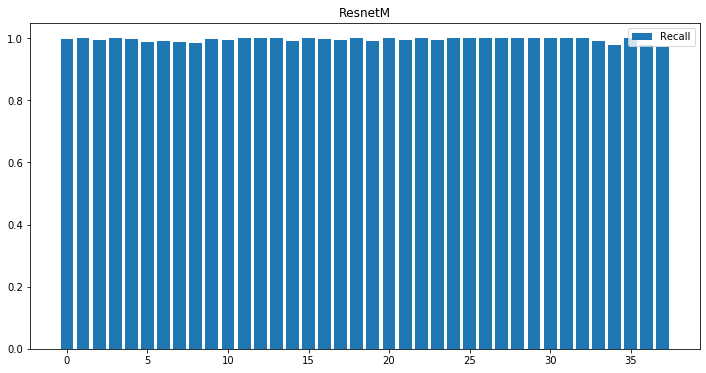

In [14]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(range(n_classes), recall, label = "Recall")
plt.legend(loc = 'best')
plt.title("ResnetM")

fig.set_figwidth(12)
fig.set_figheight(6)

<Figure size 1440x720 with 0 Axes>

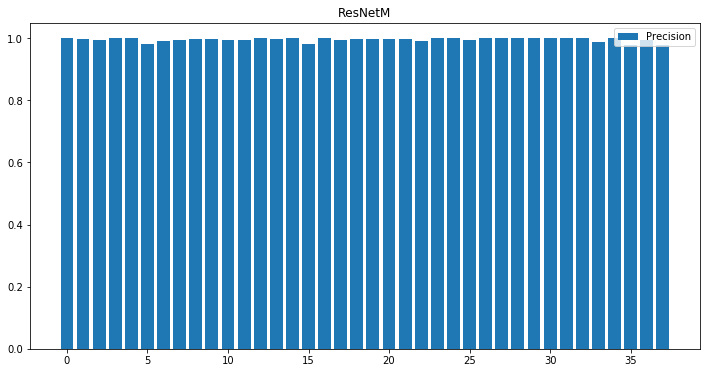

In [15]:
plt.figure(figsize = (20,10))
fig, ax = plt.subplots()

ax.bar(range(n_classes), precision, label = "Precision")
plt.legend(loc = 'best')
plt.title("ResNetM")


fig.set_figwidth(12)
fig.set_figheight(6)

In [28]:
import tensorflow as tf
from tensorflow.python.framework import graph_io
from tensorflow.keras.models import load_model

from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [31]:
def freeze_graph(graph, session, output, save_pb_dir = '.', save_pb_name = 'frozen_model.pb', save_pb_as_text=False):
    with graph.as_default():
        graphdef_inf = tf.graph_util.remove_training_nodes(graph.as_graph_def())
        graphdef_frozen = tf.graph_util.convert_variables_to_constants(session, graphdef_inf, output)
        graph_io.write_graph(graphdef_frozen, save_pb_dir, save_pb_name, as_text=save_pb_as_text)
        return graphdef_frozen

session = tf.keras.backend.get_session()
init = tf.global_variables_initializer()
session.run(init)


input_names = [t.op.name for t in model.inputs]
output_names = [t.op.name for t in model.outputs]

frozen_graph = freeze_graph(session.graph, session, [out.op.name for out in model.outputs], 
                            save_pb_dir = '.', save_pb_name = 'frozen_model_ct2_Sign_ResNetM_72X72x3_33.pb')

Instructions for updating:
Use `tf.compat.v1.graph_util.remove_training_nodes`
Instructions for updating:
Use `tf.compat.v1.graph_util.convert_variables_to_constants`
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
INFO:tensorflow:Froze 146 variables.
INFO:tensorflow:Converted 146 variables to const ops.


In [32]:
# Prints input and output nodes names, take notes of them

print(input_names, output_names)

['input_1'] ['fc5/Softmax']


# Tune 4.3

In [26]:
for photo in os.listdir(test_dir + "34"):
    imag = im.load_img(test_dir + "34/" + photo, target_size = (img_height, img_width))

    photo_ar = im.img_to_array(imag)
    photo_ar = np.expand_dims(photo_ar, axis = 0)
    photo_ar /= 255
    
    pred = np.argmax(loaded_model.predict(photo_ar))    
    if pred != 34:
        shutil.move(test_dir + "34/" + photo, train_dir + "34/" + photo)

# Tune NKBVS

In [14]:
photos_dir = "/home/linnik/Datasets/Signs/nkbvs_ts_crops_RGB/"
temp_dir = "/home/linnik/Datasets/Signs/temp/"

for img in os.listdir(photos_dir):
    imag = im.load_img(photos_dir + img, target_size = (img_height, img_width))

    photo_ar = im.img_to_array(imag)
    photo_ar = np.expand_dims(photo_ar, axis = 0)
    photo_ar /= 255

    pred = np.argmax(loaded_model.predict(photo_ar))
    
    os.makedirs(temp_dir + str(pred), exist_ok = True)
    shutil.copy(photos_dir + img, temp_dir + str(pred))